# Week 12: Colab Experiment

# I. Introduction
In this exercise, we learn an autoencoder to reconstruct the MNIST images and extract the representations.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random


In [2]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 108MB/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 21.3MB/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 47.7MB/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.52MB/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



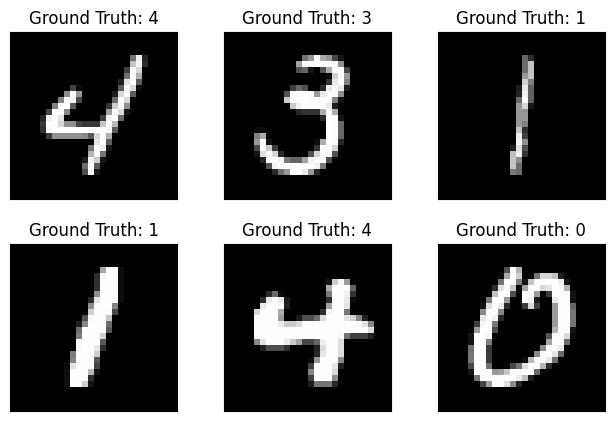

In [3]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

## II. Methods

### Objective
To design and train a lightweight autoencoder (LAutoencoder) for dimensionality reduction and reconstruction of input images, with latent feature visualization.

### Model Architecture
- **Encoder**: Maps a 784-dimensional input (flattened 28x28 images) to a 2D latent space using fully connected layers with ReLU activation.
- **Decoder**: Reconstructs the input from the 2D latent space using fully connected layers and Sigmoid activation to normalize the output.

### Training
- **Loss Function**: Mean Squared Error (MSE) to measure reconstruction error.
- **Optimizer**: AdamW optimizer with a learning rate .
- **Process**:
  1. Flatten input images for the encoder.
  2. Pass data through the encoder and decoder.
  3. Compute MSE loss and update weights using backpropagation.
  4. Track the loss at each epoch.

### Evaluation
- **Visualization**: Generate scatter plots of the 2D latent space to observe clustering of digit classes, demonstrating effective feature separation.


In [4]:
class LAutoencoder(nn.Module):  # Define the autoencoder class, inheriting from nn.Module
    def __init__(self):
        super().__init__()  # Initialize the parent class
        self.encoder = nn.Sequential(  # Define the encoder as a sequential model
            nn.Linear(28 * 28, 128),  # Fully connected layer mapping 784 to 128 dimensions
            nn.ReLU(),  # Apply ReLU activation to introduce non-linearity
            nn.Linear(128, 64),  # Fully connected layer mapping 128 to 64 dimensions
            nn.ReLU(),  # Apply ReLU activation to introduce non-linearity
            nn.Linear(64, 2),  # Fully connected layer mapping 64 to 2 dimensions (latent space)
        )
        self.decoder = nn.Sequential(  # Define the decoder as a sequential model
            nn.Linear(2, 64),  # Fully connected layer mapping 2 dimensions to 64
            nn.ReLU(),  # Apply ReLU activation to introduce non-linearity
            nn.Linear(64, 128),  # Fully connected layer mapping 64 to 128 dimensions
            nn.ReLU(),  # Apply ReLU activation to introduce non-linearity
            nn.Linear(128, 28 * 28),  # Fully connected layer mapping 128 to 784 dimensions

        )

    def forward(self, x):  # Define the forward pass of the model
        x = x.view(x.size(0), -1)  # Flatten the input images into 1D vectors
        latent = self.encoder(x)  # Pass the input through the encoder to get latent representation
        x = self.decoder(latent)  # Pass the latent representation through the decoder for reconstruction

        return x, latent  # Return the reconstructed images and the latent representation


# Training steps

In [5]:
num_epochs = 10
learning_rate = 2e-3


model = LAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data  # Load inputs; labels aren't needed for autoencoders



        # Flatten inputs to match the expected shape by the model
        inputs_flattened = inputs.view(inputs.size(0), -1)

        # Forward pass
        reconstructed, latent = model(inputs)

        # Calculate the loss
        loss = criterion(reconstructed, inputs_flattened)

        # Backward pass
        optimizer.zero_grad()  # Clear gradients

        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')








Epoch [1/10], Loss: 0.5344
Epoch [2/10], Loss: 0.4253
Epoch [3/10], Loss: 0.4244
Epoch [4/10], Loss: 0.4502
Epoch [5/10], Loss: 0.4119
Epoch [6/10], Loss: 0.4173
Epoch [7/10], Loss: 0.4467
Epoch [8/10], Loss: 0.4216
Epoch [9/10], Loss: 0.3924
Epoch [10/10], Loss: 0.3430


## III. Results

We train the autoencoder model and apply it to the test set. There is no validation set here, we simply take the model at the end of the training procedure. The scatter plot of the embeddings are shown below, with each digit colored differently.

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def scatter_plot(data_loader):

  d = {0: 'red', 1: "green", 2: "blue", 3: "maroon", 4: "yellow",
      5: "pink", 6: "brown", 7: "black", 8: "teal", 9: "aqua"}

  colors = []
  latent_variables = []
  labels = []

  for data in test_loader:
    img, label = data
    img = img.view(img.size(0), -1)
    model.cpu()
    _,latent = model(img)
    latent_variables.append(latent)
    labels.append(label)


  latent_variables = torch.cat(latent_variables, dim=0)
  labels = torch.cat(labels, dim=0)


  df = pd.DataFrame(data = latent_variables.detach().numpy(), columns = ['Latent feature 1', 'Latent feature 2'])
  df['label'] = labels.numpy()

  fig = plt.figure(dpi=200)
  sns.scatterplot(data=df, x="Latent feature 1", y="Latent feature 2", hue="label", palette="deep")
  plt.show()

The test set:


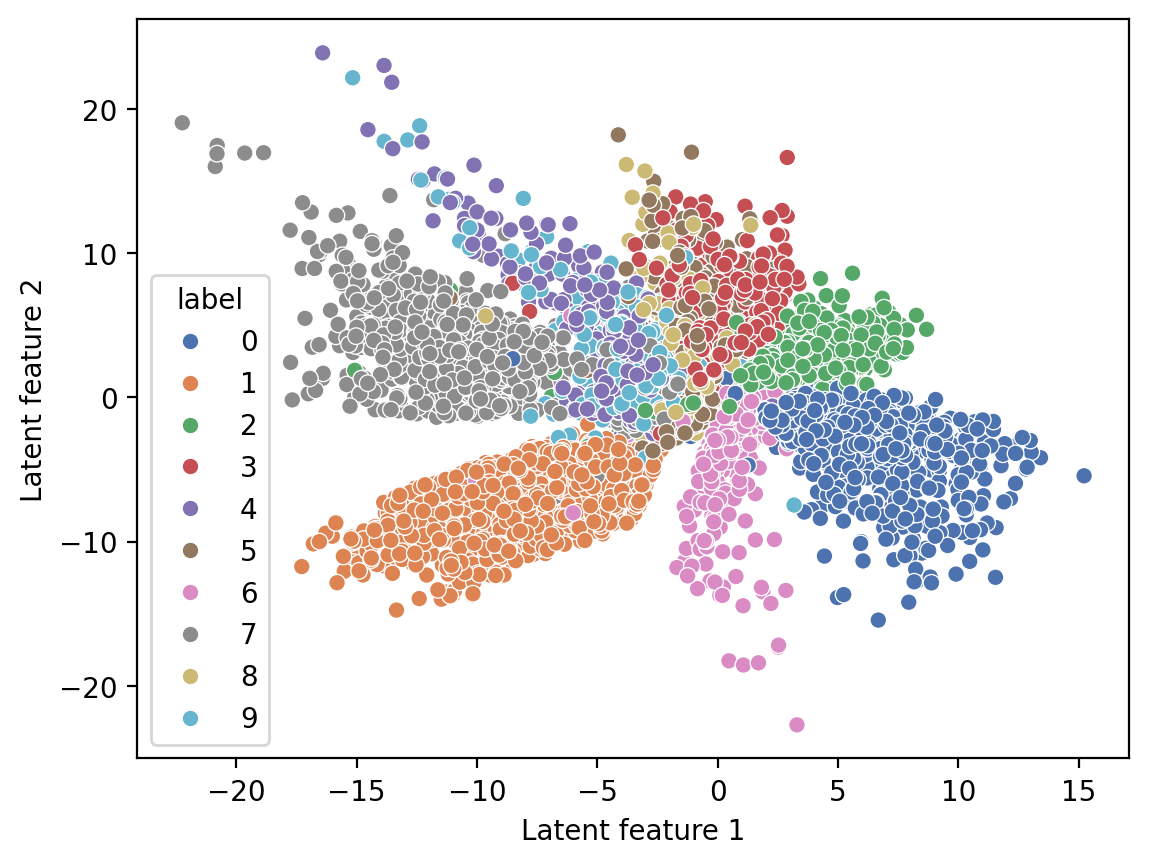

In [7]:
print("The test set:")
scatter_plot(test_loader)

## Discussion and Conclusion

The 2D latent space visualization illustrates the model's ability to condense high-dimensional input data into a meaningful representation. The autoencoder effectively captures features of the MNIST dataset, as evidenced by the distinct clusters representing digit classes. However, the overlapping regions in the latent space suggest limitations in feature separation.

### Key Observations from the Plot
- **Cluster Formation**:Data points are grouped into distinct clusters based on their labels (0–9). This indicates the autoencoder's ability to separate different classes in its latent space.
- **Class Overlap**: Some clusters partially overlap, which might suggest difficulties in distinguishing certain classes or shared features among them.
- **Dimension**: The latent features provide a reduced-dimensional representation, capturing meaningful differences while discarding noise.

### Analysis: ELU vs. ReLU
From the experiments, there is no significant difference in loss reduction when using ELU versus ReLU as the activation function. Both activation functions demonstrate similar training behaviors and convergence trends.

- **ReLU** achieves comparable loss values across epochs, with slightly better performance by the end of training in one experiment.
- **ELU**, with its smoother gradient in the negative range, may benefit models with deeper layers or more complex non-linearities, but its advantage isn't clearly observed here.

Given the results, either function is viable for this task. The choice may depend on specific architecture and dataset considerations. For this experiment, ReLU is slightly preferred for its simplicity and computational efficiency.

### Pros and Cons of the Model
#### Pros:
- **Effective Dimensionality Reduction**: Compresses data into 2D space with reasonable preservation of class relationships.
- **Interpretable Latent Space**: The visual clustering of digit classes highlights meaningful feature extraction.
- **Simplicity**: The architecture is straightforward and computationally efficient.

#### Cons:
- **Overlapping Clusters**: Overlaps between similar digits, such as "4" and "9," limit the model's discriminative power.
- **Reconstruction Limitations**: Fixed latent space dimensions may restrict the fidelity of reconstructed images.


### Proposals for Improvement
1. **Increase Latent Dimensions**:
   - Expand the latent space to 3 or more dimensions to better encode complex features.
2. **Regularization**:
   - Introduce Dropout layers in both encoder and decoder to reduce overfitting.
   - Apply Weight Decay or L2 regularization to encourage sparsity in weights.

### Conclusion
The autoencoder demonstrates solid performance in compressing and visualizing MNIST data but struggles with overlapping latent clusters and reconstruction fidelity. While both ReLU and ELU activation functions yield comparable results, the simplicity of ReLU may be advantageous for this task. Future improvements, such as increasing latent dimensions, adopting advanced loss functions, and utilizing convolutional architectures, could enhance the model's ability to separate classes and reconstruct high-quality images effectively.
